# Read me 

After the global processing, the following code allows to compute further features on a local patch.
Input : patch text files 

Output features : 
* Area approximation
* Density of B cells, T cells
* Degree statistics : 
degree with neighbors of the same phenotype ;
degree with neighbors of another phenotype
* Distance statistics
* Average local clustering coefficient

# Imports

External

In [1]:
import re
import sys
import math
import itertools
import ipywidgets
import operator
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

Internal

In [2]:
sys.path.append("../..")
import cell_graph_functions as func
from control.clustering.TissueWindower import *
from control.initialization.GraphInitializer import *
from control.initialization.GraphSignalInitializer import *
from control.initialization.SlideInitializer import *
from control.clustering.BorderIdentifier import *
from model.graph.GraphSignal import *
from model.bio.Patient import *
from model.bio.Population import *
from view.graph.GraphViewer import *

Patch to process :

In [3]:
INPUT_DIRECTORY = "./input/cell_details/subject_2/"
OUTPUT_DIRECTORY = "./input/output/subject_2/"
THRESHOLDS_DIRECTORY = "./input/treg_thresholds/"

In [4]:
# Constants
PATIENTS_DIRECTORY = "./input/cell_details"
THRESHOLDS_DIRECTORY = "./input/treg_thresholds"
NB_PATIENTS = -1
NB_TISSUES_PER_PATIENT = -1
COLUMN_X = "cell_x_position"
COLUMN_Y = "cell_y_position"
COLUMN_PHENOTYPE = "phenotype"
COLUMN_CATEGORY = "tissue_category"
COLUMN_TISSUE = "Path"
COLUMN_WINDOW = "sample_name"
SEPARATOR = "\t"

# Useful objects
slide_initializer = SlideInitializer()

# Find patient IDs
patient_ids = [patient_id for patient_id in os.listdir(PATIENTS_DIRECTORY) if patient_id[0] != "."]
patient_ids = random.sample(set(patient_ids), min(NB_PATIENTS, len(patient_ids))) if NB_PATIENTS >= 0 else patient_ids
patient_ids.sort()

# Find associated tissue IDs
window_ids = {patient_id : [window_id[:-4] for window_id in os.listdir(PATIENTS_DIRECTORY + "/" + patient_id) if window_id[0] != "."] for patient_id in patient_ids}
window_ids = {patient_id : random.sample(set(window_ids[patient_id]), min(NB_TISSUES_PER_PATIENT, len(window_ids[patient_id]))) if NB_TISSUES_PER_PATIENT >= 0 else window_ids[patient_id] for patient_id in patient_ids}

# Get corresponding cell details files and threshold files
window_files = {patient_id : [PATIENTS_DIRECTORY + "/" + patient_id + "/" + window_id + ".txt" for window_id in window_ids[patient_id]] for patient_id in patient_ids}
threshold_files = {patient_id : [THRESHOLDS_DIRECTORY + "/" + patient_id + "/" + window_id + ".txt" for window_id in window_ids[patient_id]] for patient_id in patient_ids}

# We create a slide with multiple tissues per patient
population = Population("Entire population")
print("Loading patches")
for patient_id in patient_ids :
    try :
        number = re.findall(r'\d+',patient_id)
        patient = Patient(patient_id)
        slide = slide_initializer.from_files(patient, window_files[patient_id], threshold_files[patient_id], COLUMN_WINDOW, COLUMN_X, COLUMN_Y, COLUMN_PHENOTYPE, COLUMN_CATEGORY, SEPARATOR, "Only slide")
        population.add_patient(patient)
    except IndexError:
        pass
print("done")

Loading patches
done


In [5]:
tissue = population.get_patients()[1].get_slides()[0].get_tissues()[0]
output_dir = OUTPUT_DIRECTORY + "/" + tissue.get_slide().get_patient().get_name() + "/" + tissue.get_name() + "/"
if not os.path.exists(output_dir) :
    os.makedirs(output_dir)
# Useful objects
graph_viewer = GraphViewer()
graph_initializer = GraphInitializer()
signal_initializer = GraphSignalInitializer()
border_identifier = BorderIdentifier()

Here, we can see the resulting graph by varying the distance threshold, and choose it accordingly.

In [6]:
slider = ipywidgets.IntSlider(value=40,
                              min=0,
                              max=200,
                              step=1,
                              description='Max dist :',
                              disabled=False,
                              continuous_update=False,
                              orientation='horizontal',
                              readout=True,
                              readout_format='d')

def action(dist):
    # Graph (delaunay)
    graph, dist = func.delaunay_with_thresh(tissue.get_cells(), max_dist=slider.value)
    signal = signal_initializer.from_vertex_attribute(graph, lambda vertex : vertex.get_category())
    graph_viewer.export_graph_signal(signal, OUTPUT_DIRECTORY+ tissue.get_name() + "_category.png")

ipywidgets.interact(action, dist=slider);

interactive(children=(IntSlider(value=40, continuous_update=False, description='Max dist :', max=200), Output(…

Then we build the graph with the desired threshold.

In [7]:
MAX_DIST = 40
graph, dist = func.delaunay_with_thresh(tissue.get_cells(), max_dist=MAX_DIST)

# Region border

To highlight the cells of interest in the patch, we give the region ID, and we draw the borders only around it :

In [8]:
ID = "266"

./input/output/subject_2/0_0_region_border.png


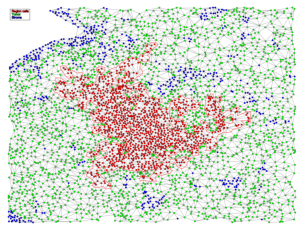

In [9]:
patch_cells = pd.read_csv(INPUT_DIRECTORY+"0_0.txt", sep=SEPARATOR)
patch_cells = patch_cells[patch_cells.region_id==ID][["cell_x_position","cell_y_position"]].values
region_cell = []
for i in range(len(tissue.get_cells())):
    for j in patch_cells:
        if (j == [tissue.get_cells()[i].get_x(),(tissue.get_cells()[i].get_y())]).all():
            region_cell.append(tissue.get_cells()[i])
            
border_lines, border_lengths = func.find_border_region(tissue, region_cell)
border_points = [[point[0] for point in line] for line in border_lines]
signal = GraphSignal(graph)
signal.set_entries(["Region cells" if cell in region_cell
                    else "Stroma" if cell.get_category()== "stroma"
                    else 'Tumor' if cell.get_category()== "tumor"
                    else 'other'
                    for cell in tissue.get_cells()])
graph_viewer.export_graph_signal(signal, OUTPUT_DIRECTORY+ tissue.get_name()+"_region_border.png", lines=border_points)

# Area and density


To approximate the area, we consider the region as an irregular polygon, its vertices being the middle point between tumor and stroma cells on the largest border.

In [10]:
lines = [len(i) for i in border_lines]
big_border_points = []
for i in range(len(border_lines[lines.index(max(lines))])) :
    big_border_points.append(border_lines[lines.index(max(lines))][i][0])
    

cell_x = [cell.get_x() for cell in region_cell]
cell_y = [cell.get_y() for cell in region_cell]
coords = [(point[0], point[1]) for point in big_border_points]

Area approximation can be sensitive in some cases, due to the numerous vertices, it is always better to visually inspect it.

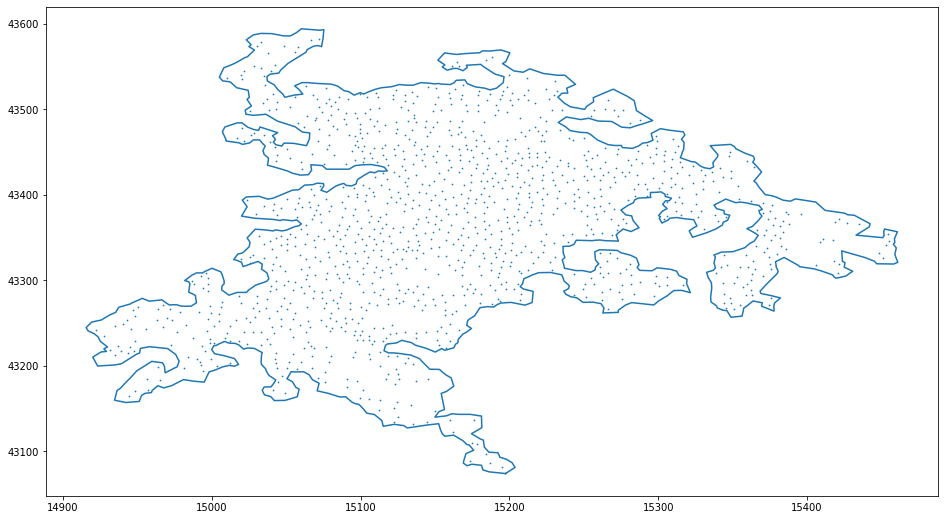

In [11]:
plt.figure(figsize=(16,9))
plt.scatter(cell_x,cell_y,s=0.5)
plt.plot([coord[0] for coord in coords], [coord[1] for coord in coords])
area = func.get_area(coords)

In [12]:
print("The estimated area is of", area)
print("Number of B cells :", func.get_density("CD20p", region_cell, area)[0], "density of B cells :", func.get_density("CD20p", region_cell, area)[1])
print("Number of T cells :", func.get_density("CD3p", region_cell, area)[0], "density of T cells :", func.get_density("CD3p", region_cell, area)[1])

The estimated area is of 96126.69625000052
Number of B cells : 625 density of B cells : 0.006501835851869263
Number of T cells : 328 density of T cells : 0.003412163455060989


# Connectedness basic features

Degree statistics on the B-cells of the region :

In [13]:
region_cell_b_cells = [cell for cell in region_cell if cell.get_phenotype()=="CD20p"]
print(len(region_cell_b_cells))
features = func.get_degree(graph, region_cell_b_cells)
features.describe()

625


degree_self  degree_other  avg_dist_self  avg_dist_other
count   625.000000    625.000000     625.000000      625.000000
mean      4.160000      1.840000       8.457532        6.961170
std       1.788496      1.740358       2.101494        5.081088
min       0.000000      0.000000       0.000000        0.000000
25%       3.000000      0.000000       7.431652        0.000000
50%       4.000000      1.000000       8.459314        8.139410
75%       5.000000      3.000000       9.535323       10.435124
max       9.000000      8.000000      16.382772       21.297089

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183b3700>,
      dtype=object)

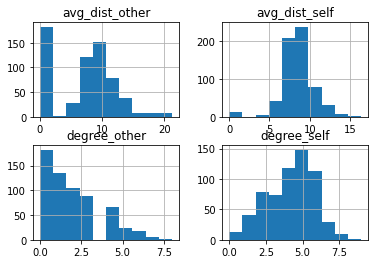

In [14]:
features.hist()

Degree statistics on the T-cells of the region :

In [15]:
region_cell_t_cells = [cell for cell in region_cell if cell.get_phenotype()=="CD3p"]
print(len(region_cell_t_cells))
features = func.get_degree(graph, region_cell_t_cells)
features.describe()

328


degree_self  degree_other  avg_dist_self  avg_dist_other
count   328.000000    328.000000     328.000000      328.000000
mean      2.237805      3.612805       8.105368       10.214586
std       1.371902      1.585317       4.030329        3.358550
min       0.000000      0.000000       0.000000        0.000000
25%       1.000000      2.000000       6.546635        8.125960
50%       2.000000      4.000000       8.008314        9.984485
75%       3.000000      5.000000       9.777591       11.741685
max       7.000000      8.000000      30.663496       29.218821

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119439730>,
      dtype=object)

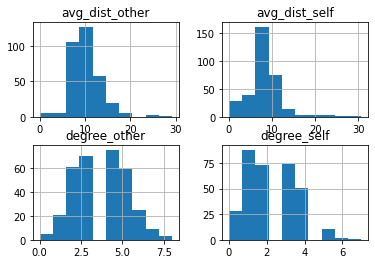

In [16]:
features.hist()

# Connectedness advanced features
## Clustering coefficient:
The degree in which the neighborhood of a node is connected, for a particular node :

Clustering coefficient = Number of closed triplets / Number of all triplets.

Where a triplet consists of three nodes with edges connecting all of them.

## Stromal clustering
clustering coefficient of stromal cells within a tumor

In [17]:
stromal_clustering = func.get_local_clustering_coeff(graph, region_cell)
stromal_clustering.describe()

local_clustering_coefficient
count                   1226.000000
mean                       0.421080
std                        0.097120
min                        0.200000
25%                        0.333333
50%                        0.400000
75%                        0.500000
max                        1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127d3a220>]],
      dtype=object)

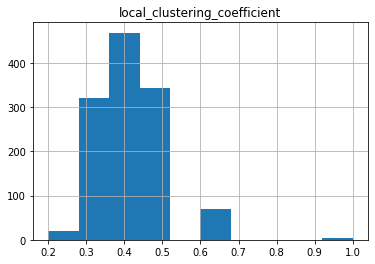

In [18]:
stromal_clustering.hist()